# Notebook 4: Clustering DBSCAN
<br>
In this notebook, we cluster the pick-up positions of the rides using DBSCAN.

In [1]:
import pandas as pd
import skmob
import numpy as np
import matplotlib.pyplot as plt
from skmob.measures.individual import *
from skmob.measures.collective import visits_per_time_unit
from skmob.utils import plot
import geopandas as gpd
from my_utils import *

C:\Users\giuli\Anaconda3\envs\skmob\lib\site-packages\tqdm\std.py:699: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


### Outline

1. [Data loading](#dataloading)
2. [DBSCAN step 1](#dbscan_1)
3. [DBSCAN step 2](#dbscan_2)
4. [Cluster analysis](#cluster_analysis)


<a id="dataloading"></a>
## 1. Data loading
Load the clean trajectory dataset and the clean ride dataset (computed in the jupyter notebook `2_data_pre_processing.ipynb`)

In [2]:
dataset_rides_path = '../data/datasets/tdf_rides_clean.zip'

#load the clean rides dataset
tdf_rides = pd.read_csv(dataset_rides_path, sep='\t', 
                        parse_dates=['start_time','end_time'], compression='zip')

In [3]:
#load the shapefile for the plots

tessellation = gpd.GeoDataFrame.from_file("../data/shapes/sanfrancisco.geojson")
geoms = [geom[0] for geom in tessellation['geometry']]
tessellation['geometry'] = geoms

<a id="dbscan_1"></a>
## 2. DBSCAN Clustering of pick-up positions

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn import metrics

In [5]:
# Take the pick-ups i.e. where occupancy==1

start_pos = tdf_rides[tdf_rides['occupancy']==1]
start_pos[:2]

,uid,traj_id,occupancy,start_lat,start_lng,start_time,end_lat,end_lng,end_time,dist_start_end,cumulative_distance,avg_speed_kmh,dt_seconds,start_hour,day
1,abboip,1,1,37.74896,-122.40619,2008-05-17 07:52:11,37.755660,-122.414395,2008-05-17 07:55:58,1.037017,1.456743,22.897152,227,7,5
3,abboip,3,1,37.75086,-122.42154,2008-05-17 08:18:59,37.751675,-122.430980,2008-05-17 08:21:45,0.834890,0.901417,21.515430,166,8,5


In [6]:
#apply a scaler when dealing with distance-based algorithms

data_dbscan = start_pos

scaler = StandardScaler()
scaler.fit(data_dbscan[['start_lat','start_lng']].values)
scaler.transform(data_dbscan[['start_lat','start_lng']])

array([[-0.59573344,  0.54435661],
       [-0.54969833, -0.22418461],
       [-0.08086718, -0.03893363],
       ...,
       [-0.42346524, -0.95267156],
       [-0.35368572, -1.25407991],
       [-0.65436762, -1.31766606]])

Computing the **DBSCAN** clustering algorithm with the following parameters:

$\epsilon=0.05$<br>
$min\_samples=150$


The following is a time-consuming cell ($\approx$ 10 min).

If the file `../data/datasets/labels_dbscan_1.zip` containing the result of the operations performed in the time-consuming cell is available, you can use `run_time_consuming_ops = False`, and the time-consuming operations won't be executed, since the cell will simply load the result file to save time.

 If you want to run the time-consuming operations anyway, set `run_time_consuming_ops = True`.

In [7]:
%%time

run_time_consuming_ops = False

if run_time_consuming_ops:
    
    X = scaler.fit_transform(data_dbscan[['start_lat','start_lng']])
    dbscan = DBSCAN(eps=0.05, min_samples=150, algorithm='auto', n_jobs=-1)
    dbscan.fit(X)
    
    data_dbscan['cluster_step_1']=dbscan.labels_
    
    #save and compress the dataset into a zip file (for future time saving)
    #save the dataframe with the column ['cluster_step_1']
    save_csv_zipped(data_dbscan[['cluster_step_1']],'labels_dbscan_1','datasets')
    print("Time consuming operations performed!")
    
else:
    data_dbscan_col = pd.read_csv("../data/datasets/labels_dbscan_1.zip", sep='\t', 
                          compression='zip')
    
    #append the cluster_step_1 column
    data_dbscan = data_dbscan.reset_index(drop=True)
    data_dbscan['cluster_step_1'] = data_dbscan_col['cluster_step_1']
    print("Time-saving file loaded!")    

Time-saving file loaded!
Wall time: 58.7 ms


No handles with labels found to put in legend.


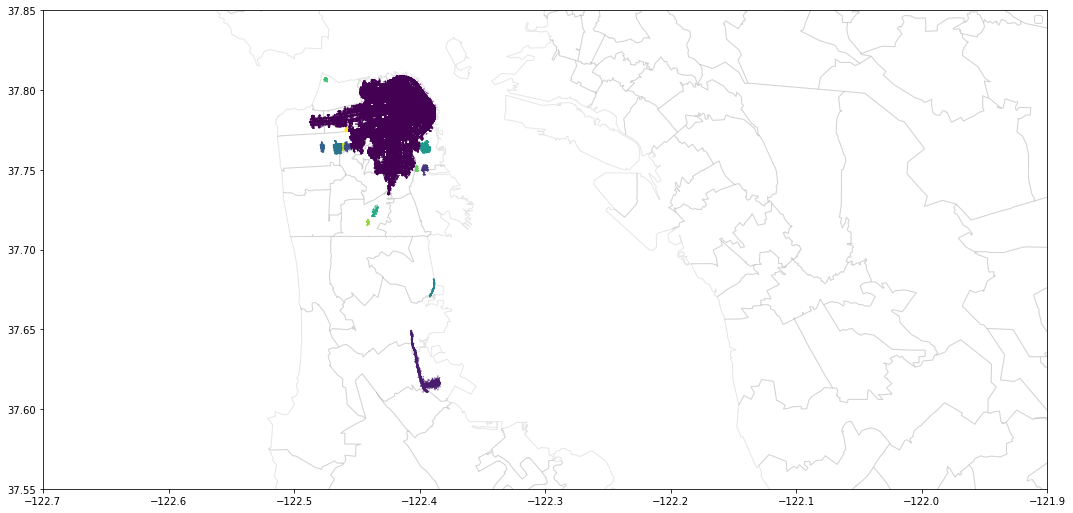

In [8]:
# visualize the clustered rides' starting point on a map

tessellation.plot(figsize=(18,10),color="white", alpha=0.2, edgecolor = "grey");

plt.ylim((37.55, 37.85))
plt.xlim((-122.7, -121.9))

data_clusters = data_dbscan[data_dbscan['cluster_step_1']!= -1]
plt.scatter(data_clusters['start_lng'], data_clusters['start_lat'], 
            c=[i for i in list(data_dbscan['cluster_step_1']) if i!=-1], s=0.5, marker='.')

plt.legend()
plt.savefig('../data/plots/dbscan_step_1.pdf')

In [9]:
# keep only the clusters with at least 1000 points

threshold = 1000

labels, counts = np.unique(data_dbscan['cluster_step_1'], return_counts=True)
clusters_2_keep = [i for i in labels[1:] if (i!=-1 and counts[1:][i] >= threshold)]
print("The labels of the clusters to keep are: "+str(clusters_2_keep))

The labels of the clusters to keep are: [0, 1, 5]


In [10]:
data_dbscan_no_noise = data_dbscan[data_dbscan['cluster_step_1'].isin(clusters_2_keep)]

print("Data DBSCAN no noise")
print("#points: "+str(len(data_dbscan_no_noise)))
print("#clusters: "+str(len(data_dbscan_no_noise['cluster_step_1'].unique())))
print("#threshold: "+str(threshold))
print("**************")
for c in clusters_2_keep:
    print("Cluster "+str(c)+": "+str(len(data_dbscan_no_noise[
        data_dbscan_no_noise['cluster_step_1']==c])))

Data DBSCAN no noise
#points: 414223
#clusters: 3
#threshold: 1000
**************
Cluster 0: 390113
Cluster 1: 22564
Cluster 5: 1546


<a id="dbscan_2"></a>
## 3. DBSCAN step 2


DBSCAN suffers from clusters with different densities, in fact, the entire center of San Francisco in a single cluster, and trying to divide it by increasing the density thresholds results in everything else being classified as noise. <br>
A solution to overcome this problem might be to apply DBSCAN a second time on high-density clusters.

In [11]:
db_downtown = data_dbscan_no_noise[data_dbscan_no_noise['cluster_step_1']==0]
db_not_downtown = data_dbscan_no_noise[data_dbscan_no_noise['cluster_step_1']!=0]

In [12]:
print("Data DBSCAN downtown")
print("#points: "+str(len(db_downtown)))
print("#clusters: "+str(len(db_downtown['cluster_step_1'].unique())))
print()
print("Data DBSCAN not downtown")
print("#points: "+str(len(db_not_downtown)))
print("#clusters: "+str(len(db_not_downtown['cluster_step_1'].unique())))

Data DBSCAN downtown
#points: 390113
#clusters: 1

Data DBSCAN not downtown
#points: 24110
#clusters: 2


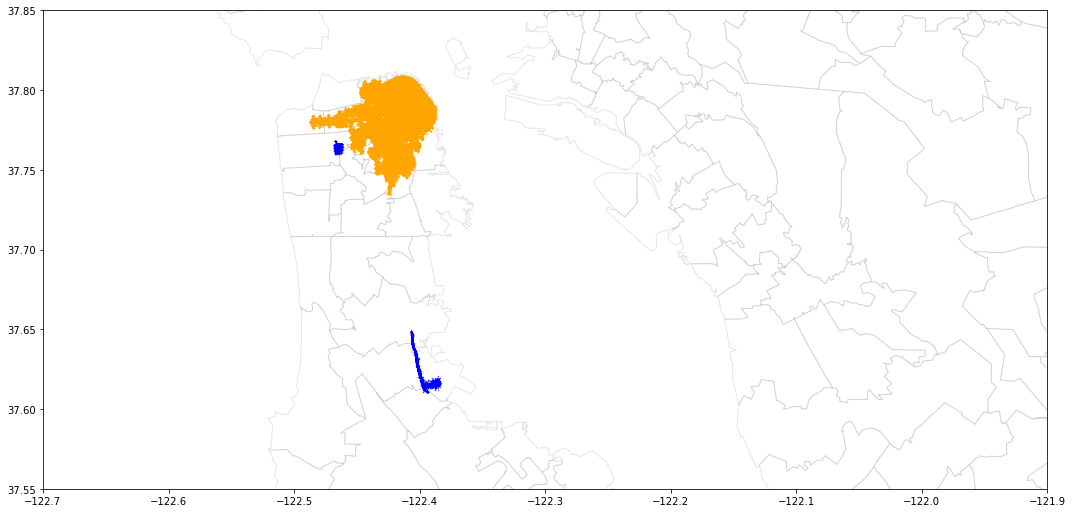

In [13]:
#let's visualize them
tessellation.plot(figsize=(18,10), color="white",alpha=0.2,edgecolor = "grey");

plt.ylim((37.55, 37.85))
plt.xlim((-122.7, -121.9))

plt.scatter(db_downtown['start_lng'], db_downtown['start_lat'], 
            c='orange', s=0.5, marker='.')

plt.scatter(db_not_downtown['start_lng'], db_not_downtown['start_lat'], 
            c='blue', s=0.5, marker='.')

#### apply (again) DBSCAN at the downtown cluster
Computing the **DBSCAN** clustering algorithm at the cluster located in the downtown of San Francisco with the following parameters:

$\epsilon=0.08$<br>
$min\_samples=4000$


In [14]:
scaler2 = StandardScaler()
scaler2.fit(db_downtown[['start_lat','start_lng']].values)
scaler2.transform(db_downtown[['start_lat','start_lng']])

array([[-2.56104221, -0.29490402],
       [-1.10291994, -0.05644257],
       [-2.32291992, -0.10542384],
       ...,
       [ 1.07333698, -0.35355265],
       [ 0.91358405, -1.19461263],
       [-2.16844185, -1.23263756]])

The following is a time-consuming cell ($\approx$ 4 min).

If the file `../data/datasets/labels_dbscan_2.zip` containing the result of the operations performed in the time-consuming cell is available, you can use `run_time_consuming_ops = False`, and the time-consuming operations won't be executed, since the cell will simply load the result file to save time.

 If you want to run the time-consuming operations anyway, set `run_time_consuming_ops = True`.

In [15]:
%%time

run_time_consuming_ops = False

if run_time_consuming_ops:
    
    X_downtown = scaler2.fit_transform(db_downtown[['start_lat','start_lng']])
    dbscan_step2 = DBSCAN(eps=0.08, min_samples=4000, algorithm='auto', n_jobs=-1)
    dbscan_step2.fit(X_downtown)
    
    db_downtown['cluster_step_1'] = dbscan_step2.labels_
    
    #save and compress the dataset into a zip file (for future time saving)
    #save the dataframe with the column ['cluster_step_1']
    save_csv_zipped(db_downtown[['cluster_step_1']],'labels_dbscan_2','datasets')
    print("Time consuming operations performed!")
    
else:
    db_downtown_col = pd.read_csv("../data/datasets/labels_dbscan_2.zip", sep='\t', 
                          compression='zip')
    
    db_downtown = db_downtown.reset_index(drop=True)
    db_downtown['cluster_step_1'] = db_downtown_col['cluster_step_1']
    print("Time-saving file loaded!")   

Time-saving file loaded!
Wall time: 59 ms


No handles with labels found to put in legend.


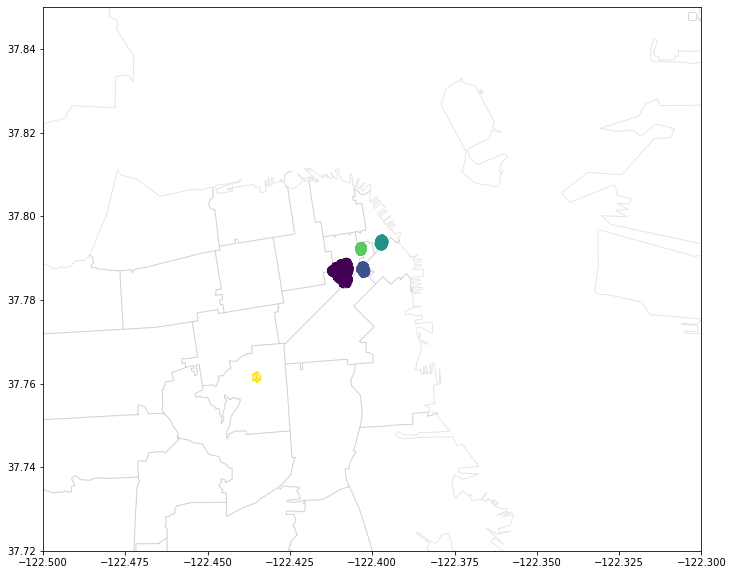

In [16]:
# visualize the clustered points in downtown

tessellation.plot(figsize=(18,10),
               color="white",
                  alpha=0.2,
               edgecolor = "grey");

plt.ylim((37.72, 37.85))
plt.xlim((-122.5, -122.3))

data_clusters = db_downtown[db_downtown['cluster_step_1'] != -1]

plt.scatter(data_clusters['start_lng'], data_clusters['start_lat'], 
            c=[i for i in list(db_downtown['cluster_step_1']) if i!=-1], s=0.5, marker='.')

plt.legend()
plt.savefig('../data/plots/dbscan_step_2.pdf')

In [17]:
# keep only the clusters with at least 1000 points

threshold = 1000

labels, counts = np.unique(db_downtown['cluster_step_1'], return_counts=True)

clusters_2_keep_2 = [i for i in labels[1:] if (i!=-1 and counts[1:][i] >= threshold)]

print("The labels of the clusters to keep are: "+str(clusters_2_keep_2))

The labels of the clusters to keep are: [0, 1, 2, 3, 4]


In [18]:
db_downtown_label = db_downtown[db_downtown['cluster_step_1'].isin(clusters_2_keep_2)]
db_downtown_label['cluster_step_1'] = db_downtown_label['cluster_step_1'] * 10
db_downtown_label['cluster_step_1'].unique()

array([ 0, 40, 10, 20, 30], dtype=int64)

In [19]:
# merge together db_downtown_label and db_not_downtown

print("DB_downtown: "+str(len(db_downtown_label)))
print("DB_not_downtown: "+str(len(db_not_downtown)))
print("expected: "+str(len(db_downtown_label)+len(db_not_downtown)))
db_final = db_downtown_label.append(db_not_downtown)
print()
print("Data FINAL")
print("#points: "+str(len(db_final)))
print("#clusters: "+str(len(db_final['cluster_step_1'].unique())))

DB_downtown: 60306
DB_not_downtown: 24110
expected: 84416

Data FINAL
#points: 84416
#clusters: 7


In [20]:
#save and compress the dataset into a zip file (for future time saving)
save_csv_zipped(db_final,'trips_clustered_dbscan_final','datasets')

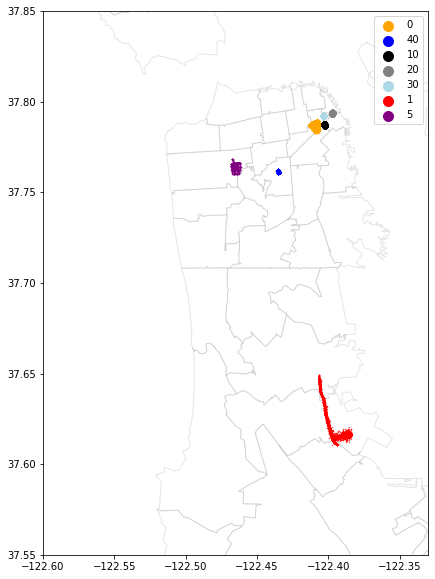

In [21]:
## let's visualize the final clusters

tessellation.plot(figsize=(18,10),
               color="white",
                  alpha=0.2,
               edgecolor = "grey");

plt.ylim((37.55, 37.85))
plt.xlim((-122.6, -122.33))

colors = ['orange', 'blue', 'black', 'grey', 'lightblue', 'red', 'purple', 'green']

for ind, lab in enumerate(db_final['cluster_step_1'].unique()):
    data_2_plot = db_final[db_final['cluster_step_1']==lab]
    
    plt.scatter(data_2_plot['start_lng'], data_2_plot['start_lat'], 
                 s=0.5, marker='.',c=colors[ind])
    plt.scatter(0,0, s=100, marker='o', label=lab, c=colors[ind])

plt.legend()
plt.savefig('../data/plots/dbscan_final.pdf')

<a id="cluster_analysis"></a>
## 4. Cluster analysis

Characterize the clusters

In [22]:
#get the centroid of each cluster

db_final.groupby(['cluster_step_1'], as_index=False).mean()[['cluster_step_1','start_lat','start_lng']]

,cluster_step_1,start_lat,start_lng
0,0,37.786649,-122.409132
1,1,37.618330,-122.392417
2,5,37.764279,-122.465339
3,10,37.787255,-122.402640
4,20,37.793705,-122.397181
5,30,37.792212,-122.403348
6,40,37.761497,-122.435084


Clusters 0, 10, 20, and 30 are located in the Financial District.<br>
Cluster 40 is located in the proximity of Twin Peaks.<br>
Cluster 5 is located near the San Francisco Botanical Garden.<br>
Cluster 1 corresponds to the San Francisco International Airport. <br>

### taxis' circadian rhythm in each cluster

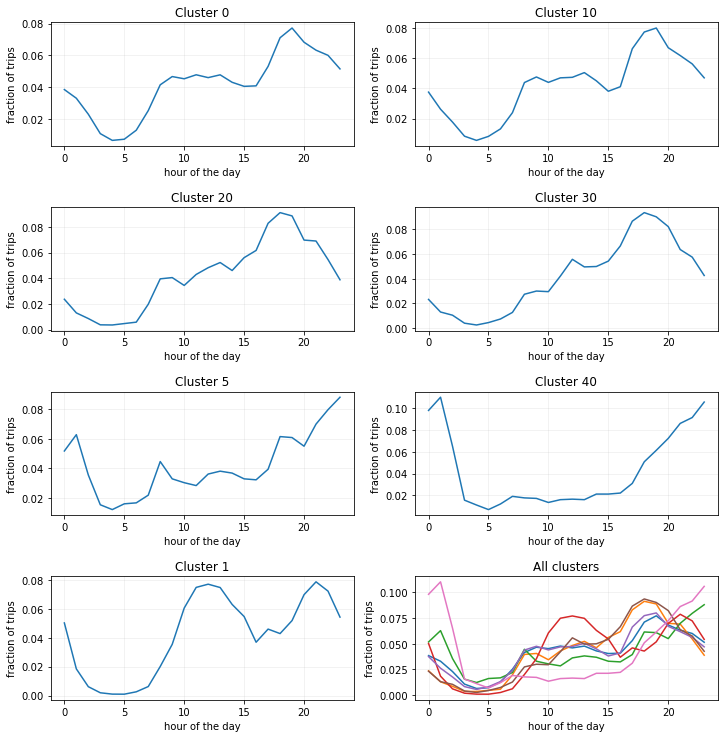

In [23]:
fig, axs = plt.subplots(4,2, sharex=False, sharey=False, figsize=(10,10),constrained_layout=True)
fig.tight_layout(h_pad=4, w_pad=3)

clusters_lab = list(db_final['cluster_step_1'].unique())

clusters_col_1 = [0,20,5,1]
clusters_col_2 = [10,30,40]

for ind, lab in enumerate(clusters_col_1):
    y_ = list(db_final[db_final['cluster_step_1']==lab].groupby("start_hour").count()['traj_id'])
    y_norm = np.array(y_)/np.array(y_).sum()
    axs[ind][0].plot(np.arange(24),y_norm)
    axs[ind][0].grid(alpha=0.2)
    axs[ind][0].set_xlabel('hour of the day')
    axs[ind][0].set_ylabel('fraction of trips')
    axs[ind][0].set_title("Cluster "+str(lab))
    axs[3][1].plot(np.arange(24),y_norm)
    
for ind, lab in enumerate(clusters_col_2):
    y_ = list(db_final[db_final['cluster_step_1']==lab].groupby("start_hour").count()['traj_id'])
    y_norm = np.array(y_)/np.array(y_).sum()
    axs[ind][1].plot(np.arange(24),y_norm)
    axs[ind][1].grid(alpha=0.2)
    axs[ind][1].set_xlabel('hour of the day')
    axs[ind][1].set_ylabel('fraction of trips')
    axs[ind][1].set_title("Cluster "+str(lab))
    axs[3][1].plot(np.arange(24),y_norm)
    
axs[3][1].grid(alpha=0.2)
axs[3][1].set_xlabel('hour of the day')
axs[3][1].set_ylabel('fraction of trips')
axs[3][1].set_title("All clusters")
plt.savefig('../data/plots/dbscan_circadian_rhythm.pdf', bbox_inches='tight')

As shown by the plot that presents the circadian rhythms of the taxis in each cluster, clusters 0 and 10 that are geographically close also show a similar trend characterized by a period of requests between 8 am and 4 pm and a peak at 7 pm.<br>

 Clusters 20 and 30, also geographically close, present a similar trend characterized by many trips that grow with the passing of the hours until it reaches its maximum around 6 pm and then decreases until 4 am. <br>

 Cluster 5 has a peak at 6 pm, one hour after the park closes, the visitors after the closing time are likely to use a taxi to get to their home or hotel.<br>

 Cluster 40, near the Twin Peaks viewpoint, features a circadian rhythm that is flat during the day and then increases reaching its peak during the evening and night, to admire San Francisco during the sunset and illuminated by the artificial lights of its skyscrapers.<br>

 Cluster 1, which coincides with the airport and therefore includes the trips that bring arriving passengers to the city center, has two peaks of departures, at noon and 9 pm.<br>

### Average traveled distance in each cluster

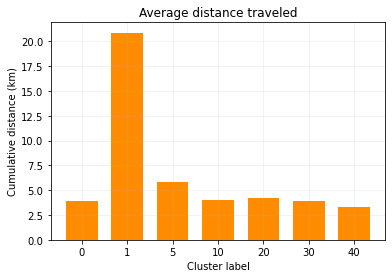

In [24]:
grp_dist = db_final.groupby("cluster_step_1",as_index=False).mean()[['cluster_step_1','cumulative_distance']]
plt.bar(np.arange(0,7), grp_dist['cumulative_distance'], color='darkorange', width=0.7)
plt.grid(alpha=0.2)
plt.xticks(ticks=np.arange(0,7),labels=grp_dist['cluster_step_1'])
plt.title("Average distance traveled")
plt.xlabel("Cluster label")
plt.ylabel("Cumulative distance (km)")
plt.savefig('../data/plots/dbscan_avg_distance.pdf')

The distance traveled during the rides started in the clusters located in the center of San Francisco indicates that, on average, the rides starting from them always end within the downtown area. As regards the average distance of the cluster at the airport, we find once again in the course of the analysis the value of 20 km, which indicates the distance between the airport and downtown, indicating how the rides that start at the airport are destined for the center city (e.g., to reach the hotel).

### Average traveled distance in each cluster

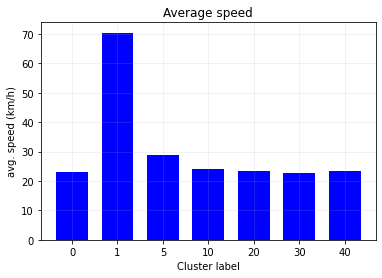

In [25]:
grp_spd = db_final.groupby("cluster_step_1",as_index=False).mean()[['cluster_step_1','avg_speed_kmh']]
plt.bar(np.arange(0,7), grp_spd['avg_speed_kmh'], color='blue', width=0.7)
plt.grid(alpha=0.2)
plt.xticks(ticks=np.arange(0,7),labels=grp_dist['cluster_step_1'])
plt.title("Average speed")
plt.xlabel("Cluster label")
plt.ylabel("avg. speed (km/h)")
plt.savefig('../data/plots/dbscan_avg_speed.pdf')

The average speed of runs starting from a cluster in downtown San Francisco is limited by the traffic and the type of urban roads, while the average speed of rides starting from the airport is higher as the US-101 N highway is traveled, which connects the airport and the city center.